<a href="https://colab.research.google.com/github/nacharya114/notebooks/blob/main/Pytorch_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Neural Style Transfer

This notebook is an exercise in translating the algorithm for Neural Style Transfer found [here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) and applying it in pytorch. This will involve using a pretrained model (VGG19), interoperating on its convolutional layers to get feature vectors, and finally, loss function manipulation with gradient descent to go from a white noise image to the properly style transfered image.

We'll  be making torch.nn modules for each step so that at the end, we can compose an end-to-end image to image model.


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Check the hardware we're running on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Image Manipulation

Before we start with the model, lets make sure we have our handles on image processing. This will technically be considered pre-processing for our model, because we only want our model to deal with tensors.

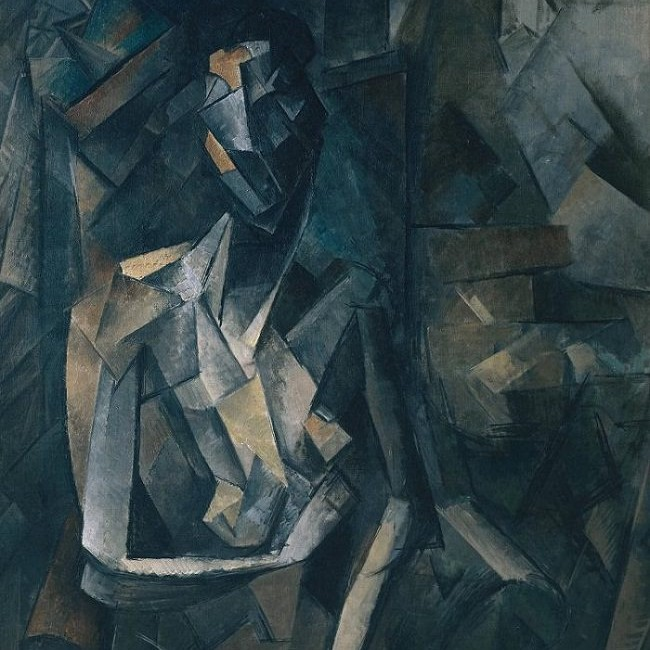

In [ ]:
# Straight from the pytorch example page:
# Download an example image from the pytorch website
import urllib
from IPython.display import Image, display


url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)


url, filename = ("https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg", "picasso.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

display(Image('picasso.jpg'))
# if you don't see the image its because it was huge.

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

imsize = 512 if torch.cuda.is_available() else 256

def image_to_tensor(filename):
  input_image = Image.open(filename)
  preprocess = transforms.Compose([
      transforms.Resize(imsize),
      transforms.CenterCrop(imsize),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  return input_batch.to(device)

input_batch = image_to_tensor(filename)
input_batch

tensor([[[[-1.2959, -1.4158, -1.4672,  ..., -0.4397, -0.5253, -0.4739],
          [-1.4500, -1.5014, -1.5357,  ..., -0.5253, -0.5424, -0.4911],
          [-1.5185, -1.4672, -1.4672,  ..., -0.4226, -0.4911, -0.4911],
          ...,
          [-1.4843, -1.4158, -1.3987,  ..., -1.5357, -1.5185, -1.5185],
          [-1.5014, -1.4158, -1.3815,  ..., -1.5528, -1.5528, -1.5699],
          [-1.4843, -1.3644, -1.3473,  ..., -1.5528, -1.6042, -1.6213]],

         [[-0.8452, -0.9678, -1.0203,  ..., -0.1800, -0.2675, -0.2325],
          [-1.0028, -1.0553, -1.0903,  ..., -0.2675, -0.3025, -0.2500],
          [-1.0728, -1.0203, -1.0203,  ..., -0.1625, -0.2500, -0.2675],
          ...,
          [-1.0728, -1.0028, -0.9853,  ..., -1.1954, -1.1779, -1.1779],
          [-1.0903, -1.0028, -0.9678,  ..., -1.1779, -1.1954, -1.2129],
          [-1.1078, -0.9853, -0.9678,  ..., -1.1779, -1.2304, -1.2479]],

         [[-0.4798, -0.5844, -0.6367,  ..., -0.1487, -0.2358, -0.2010],
          [-0.6541, -0.6890, -

In [ ]:
style_img = image_to_tensor("./picasso.jpg")
content_img = image_to_tensor("./dog.jpg")
print(style_img.size(), content_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


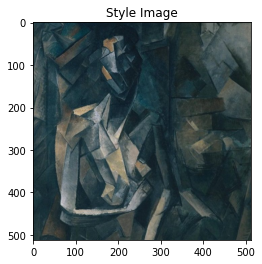

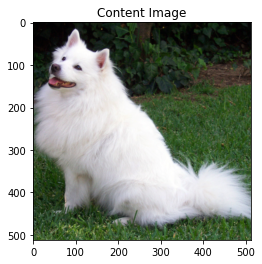

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it

    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
      ) 
    image = inv_normalize(image) # inverse the normalization we did on the image

    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Model Manipulation
The model we'll be using is a pretrained neural network called VGGNet19, as cited in the paper. It is normally used in multi class object recogntion of 1000 classes as labelled in ImageNet, but we will be discarding all the results of the fully connected layers.

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
model.eval()
model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

As we can see from above, this model has a whooping 16 convolutional layers in all. Keep this cell top of mind, since we'll need that list later. It also has the pooling and classification layer at the end, but for our purposes, we don't need those...

But for fun, lets try it out on a random image and see what it returns. 

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-12-09 17:21:56--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-12-09 17:21:56 (72.0 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
with torch.no_grad():
    output = model(content_img)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.9119455814361572
Pomeranian 0.028800439089536667
keeshond 0.01328814122825861
Great Pyrenees 0.00870680995285511
white wolf 0.00841981265693903


Cute dog! So now that we've had our fun, lets get down to business. 

## Deep Image Representations

So from here on out we'll be deep diving on the particular sections of the paper to fully explain what's going on. And we're going to start with how VGG is representing the image. As we mentioned before, VGG uses **Convolutional Layers** with parameterized weights and biases to learn different learned representations of imgae features. These filters may or may not cause activations in these layers, indicating whether or not that pattern is present. The paper surmises that we can use the activation values of these filters as a proxy for different features in the image (i.e.) a certain filter in a certain convolutional layer may indicate that an edge is present there. If we take the activation, that tells us that the edge was present. Using this knowledge, we can pick apart and combine the outputs of different layers of the model to create our own features. 


### Content Representation

The deeper we go into the layers, the higher level of abstraction the filters take on. At the same time, the more abstracted you get, the less detailed you are. Therefore, if you were to take the feature vector of the final convolutional layer, the image would have very little fine grain detail, but it would still have some semblance of what was in it.

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


### Style Representation

Style is abstracted via a combination of layers in the model.
Yada yada do this later.

We use layers 

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


## Loss Functions

Now that we have our representations, we need a way to combine them for the target picture. For that, we have a loss function: what the algorithm tries to minimize when it changes pixels in the image via backpropagation. This loss will be a combination of the difference in our content represenation  and and the difference in the style representation. 

In [ ]:
# From pytorch tutorial
import torch.nn.functional as F

def content_loss(input, target):
        loss = F.mse_loss(input.detach(), target.detach())
        return loss

def style_loss(input, target):
        loss = F.mse_loss(input.detach(), target.detach())
        return loss

## Neural Style Transfer Algorithm

In [ ]:
class NeuralStyleTransferModel(torch.nn.Module):

  def __init__(self, content_img, style_img, content_layers=["conv4_2"], 
               style_layers=["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]):
    super().__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = nn.Sequential()
    self.content_losses = []
    self.style_losses = []
    vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True).to(self.device)

    i = 1
    j = 1
    for layer in vgg.features.children():
      if isinstance(layer, nn.Conv2d):
        name = f"conv{i}_{j}"
        
      
      elif isinstance(layer, nn.MaxPool2d):
        name = f"maxpool_{i}"
        i += 1
        j = 1

      elif isinstance(layer, nn.ReLU):
        name = f"relu_{i}_{j}"
        j += 1
        layer = nn.ReLU(inplace=False)
      else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))



      self.model.add_module(name, layer)
      
      if name in content_layers:
        target = self.model(content_img).detach()
        content_ls = ContentLoss(target)
        self.content_losses.append(content_ls)
        self.model.add_module(f"cont_loss_{i}_{j}", content_ls)
        
      
      if name in style_layers:
        target = self.model(style_img).detach()
        style_ls = StyleLoss(target)  
        self.style_losses.append(style_ls)
        self.model.add_module(f"style_loss_{i}_{j}", style_ls)
      
      if len(self.content_losses) == len(content_layers) and \
        len(self.style_losses) ==len(style_layers):
        break
  def forward(self, img):
    return self.model(img)


In [ ]:
def neural_style_transfer(content_img, style_img, num_steps=1200, style_weight=10000, content_weight=1):

  input_img = content_img.clone()
  plt.figure()
  imshow(input_img, "Input Image")
  input_img.requires_grad_(True)

  nst_model = NeuralStyleTransferModel(content_img, style_img).to(device)
  nst_model.requires_grad_(False)



  optimizer = torch.optim.LBFGS([input_img])

  progress_steps = num_steps / 12

  run = [0]
  while run[0] < num_steps:

    def closure():

      # print(optimizer)
      optimizer.zero_grad()
    
      with torch.no_grad():
        input_img.clamp_(0,1)

      nst_model(input_img)

      content_loss = 0
      style_loss = 0

      for cl in nst_model.content_losses:
        content_loss += cl.loss
      
      for sl in nst_model.style_losses:
        style_loss += sl.loss
      
      style_score = style_loss * style_weight
      content_score = content_loss * content_weight

      total_loss = style_score + content_score

      total_loss.backward()
      

      run[0] += 1
      if run[0] % progress_steps == 0:
        # print(f"Step {run}: ")
        # print(f"{total_loss}, {content_loss}, {style_loss}")
        # print(input_img.grad.shape)

        plt.figure()
        imshow(input_img, total_loss.item())
      return style_score + content_score
      
    optimizer.step(closure)

  with torch.no_grad():
    input_img.clamp_(0, 1)

  return input_img



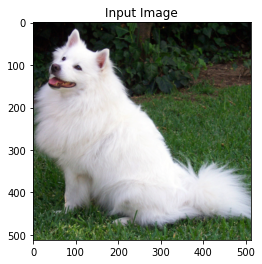

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Step [100]: 
8.341745376586914, 4.568733215332031, 0.0003773012140300125
torch.Size([1, 3, 512, 512])


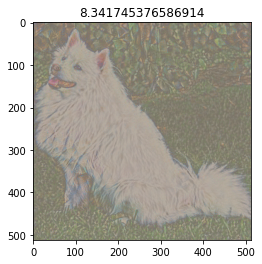

Step [200]: 
7.394081115722656, 3.899183988571167, 0.00034948968095704913
torch.Size([1, 3, 512, 512])


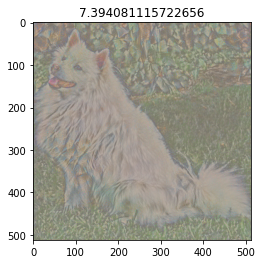

Step [300]: 
8.230725288391113, 4.3235650062561035, 0.0003907160134986043
torch.Size([1, 3, 512, 512])


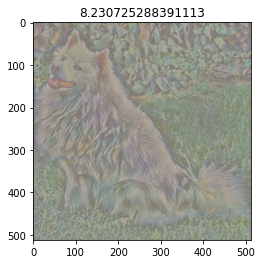

Step [400]: 
135.7584991455078, 28.194042205810547, 0.010756445117294788
torch.Size([1, 3, 512, 512])


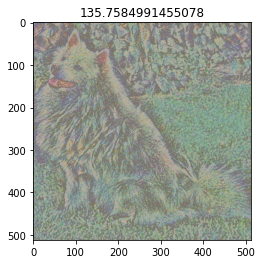

Step [500]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


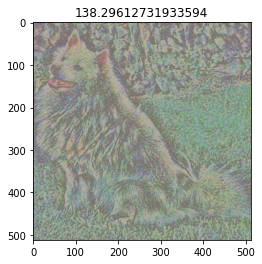

Step [600]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


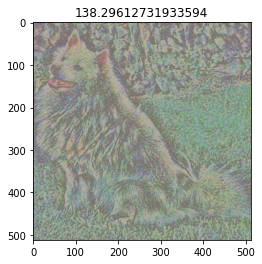

Step [700]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


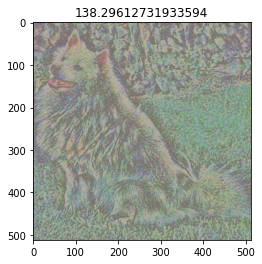

Step [800]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


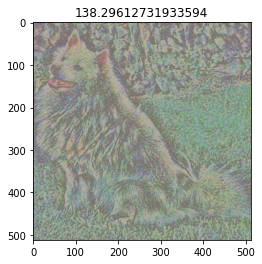

Step [900]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


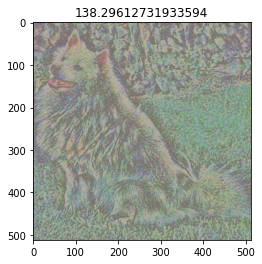

Step [1000]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


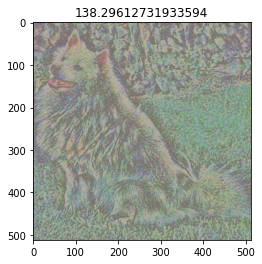

Step [1100]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


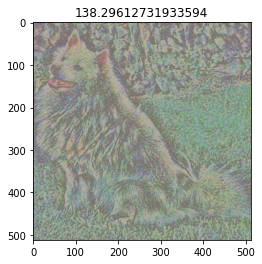

Step [1200]: 
138.29612731933594, 28.556777954101562, 0.010973935015499592
torch.Size([1, 3, 512, 512])


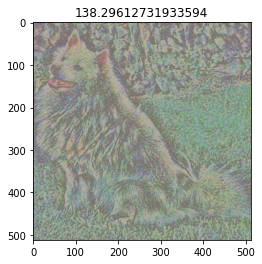

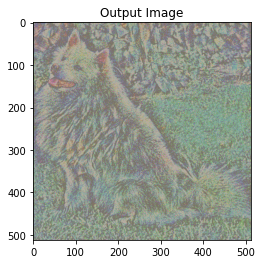

In [ ]:
output = neural_style_transfer(content_img, style_img)



plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


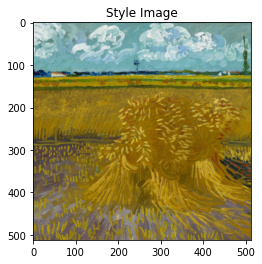

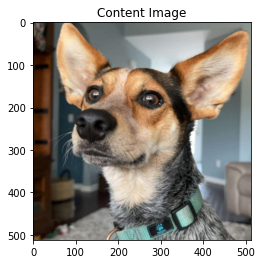

In [ ]:
content_img = image_to_tensor("echo.jpg")
style_img = image_to_tensor("lantern.jpg")

print(content_img.size(), style_img.size())

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')



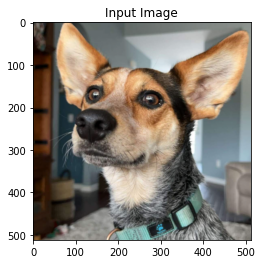

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


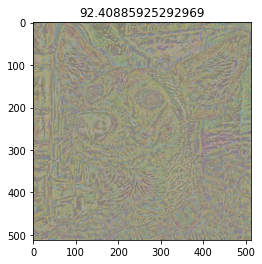

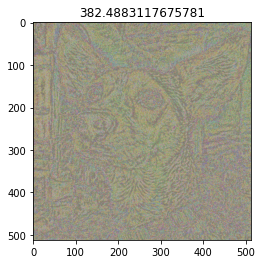

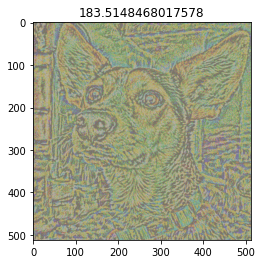

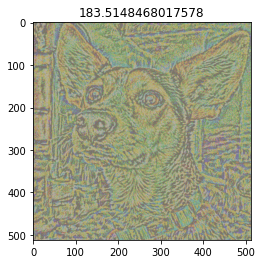

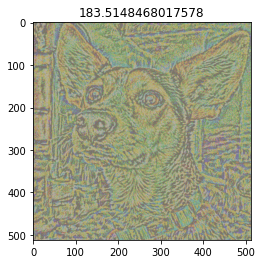

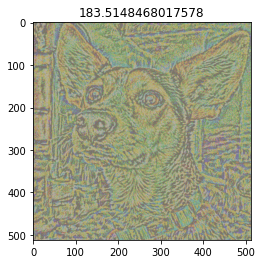

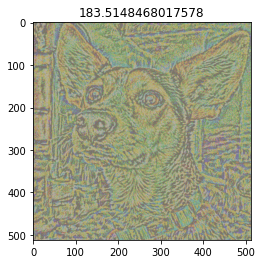

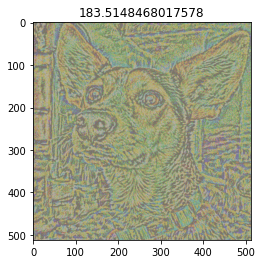

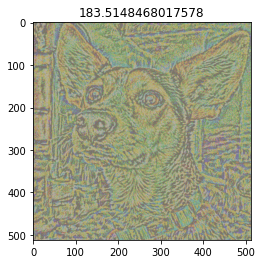

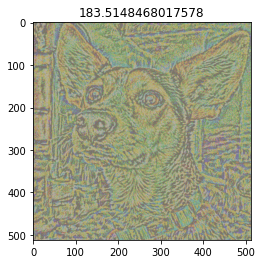

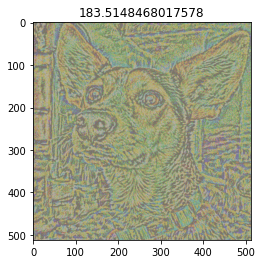

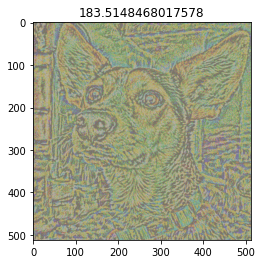

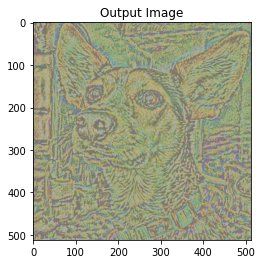

In [ ]:
output = neural_style_transfer(content_img, style_img)



plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()